In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import numpy as np
import pprint

# Qiskit imports
# from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
# from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Qiskit quantum simulator
from qiskit_aer import AerSimulator


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="DIN NYCKEL HÄR",overwrite = True)
service = QiskitRuntimeService()



In [3]:
num_qubits = 5
simulate = True

# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
# backend_name = "ibm_brussels"
backend_name = "ibm_kyiv"
backend = service.backend(backend_name)



if simulate:
    backend = AerSimulator.from_backend(backend)
    backend_name += "_simulator"


backend

AerSimulator('aer_simulator_from(ibm_kyiv)'
             noise_model=<NoiseModel on ['x', 'reset', 'id', 'measure', 'sx', 'ecr']>)

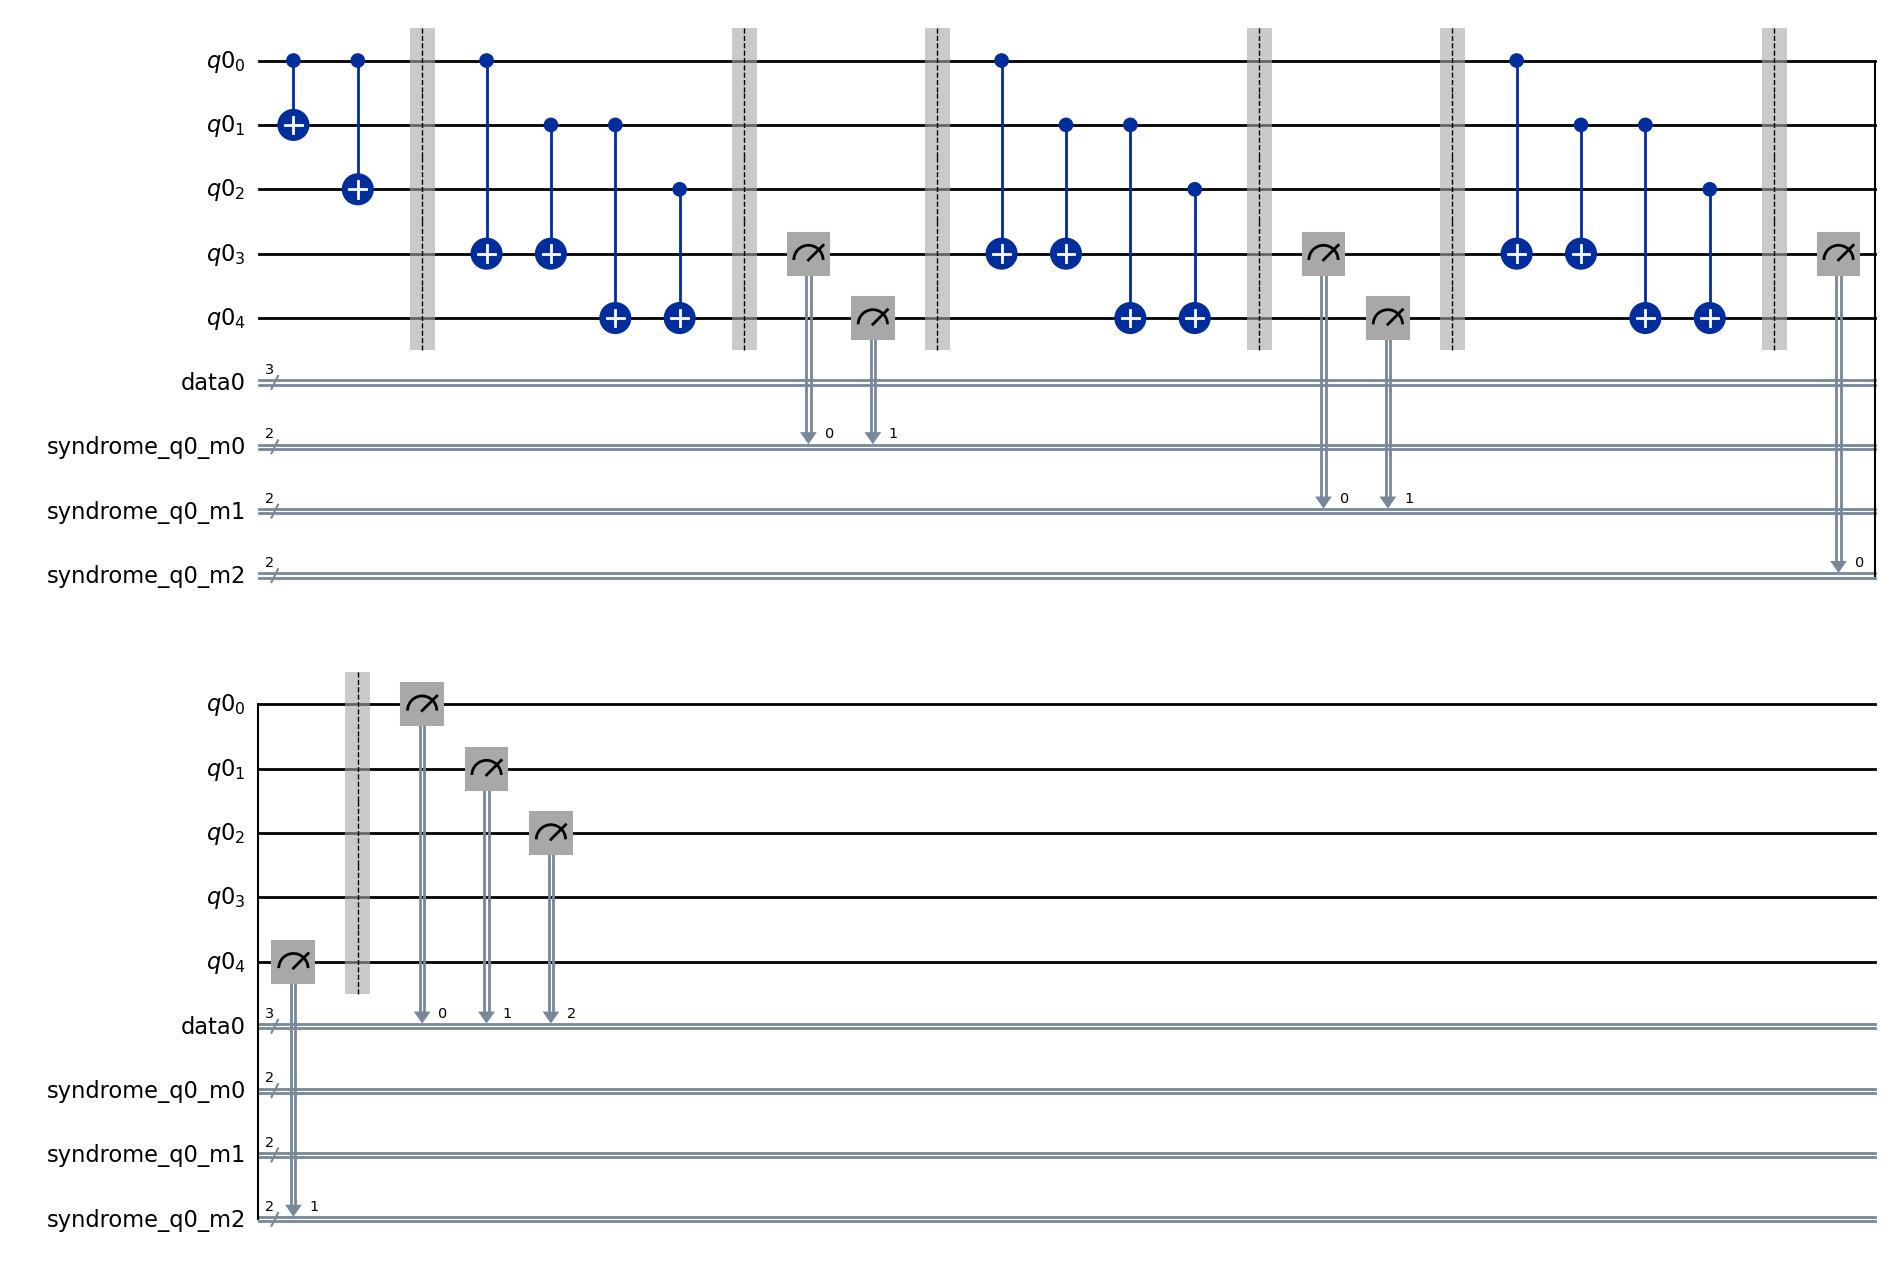

In [4]:


def gen_circuit(k=1, d=3, n_measure = 1):

    # qubits ordered by logical qubit
    qreg_q = [QuantumRegister(2*d-1, f"q{i}") for i in range(k)]

    # Data register ordered by logical qubit
    creg_data = [ClassicalRegister(d, f"data{i}") for i in range(k)]

    # Syndrome register ordered by logical qubit with capacity for multiple measurements
    creg_syndromes = sum([[ClassicalRegister((d-1), f"syndrome_q{i}_m{m}") for m in range(n_measure)] for i in range(k)],[])

    # print(creg_syndromes)
    # print(creg_data)

    circuit = QuantumCircuit(*qreg_q, *creg_data, *creg_syndromes)


    for i in range(k):

        # Entangle redundancy qubits
        for j in range(1,d):
            circuit.cx(qreg_q[i][0], qreg_q[i][j])

        # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
        circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for m in range(n_measure):
            # Stabilizer computation
            for j in range(d-1):
                circuit.cx(qreg_q[i][j], qreg_q[i][d+j])
                circuit.cx(qreg_q[i][j+1], qreg_q[i][d+j])

            # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

            # Measure syndrome
            for j in range(d-1):
                circuit.measure(qreg_q[i][j+d], creg_syndromes[i*n_measure+m][j])

        
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for j in range(d):
            circuit.measure(qreg_q[i][j], creg_data[i][j])
        # circuit.measure(qreg_q[1], creg_data[1])
        # circuit.measure(qreg_q[2], creg_data[2])

    return circuit



logic_qubits = 1
qubits_per_logical = 3
number_of_measurements = 3


circuit = gen_circuit(logic_qubits,qubits_per_logical,number_of_measurements)

circuit.draw(output="mpl", style='iqp')




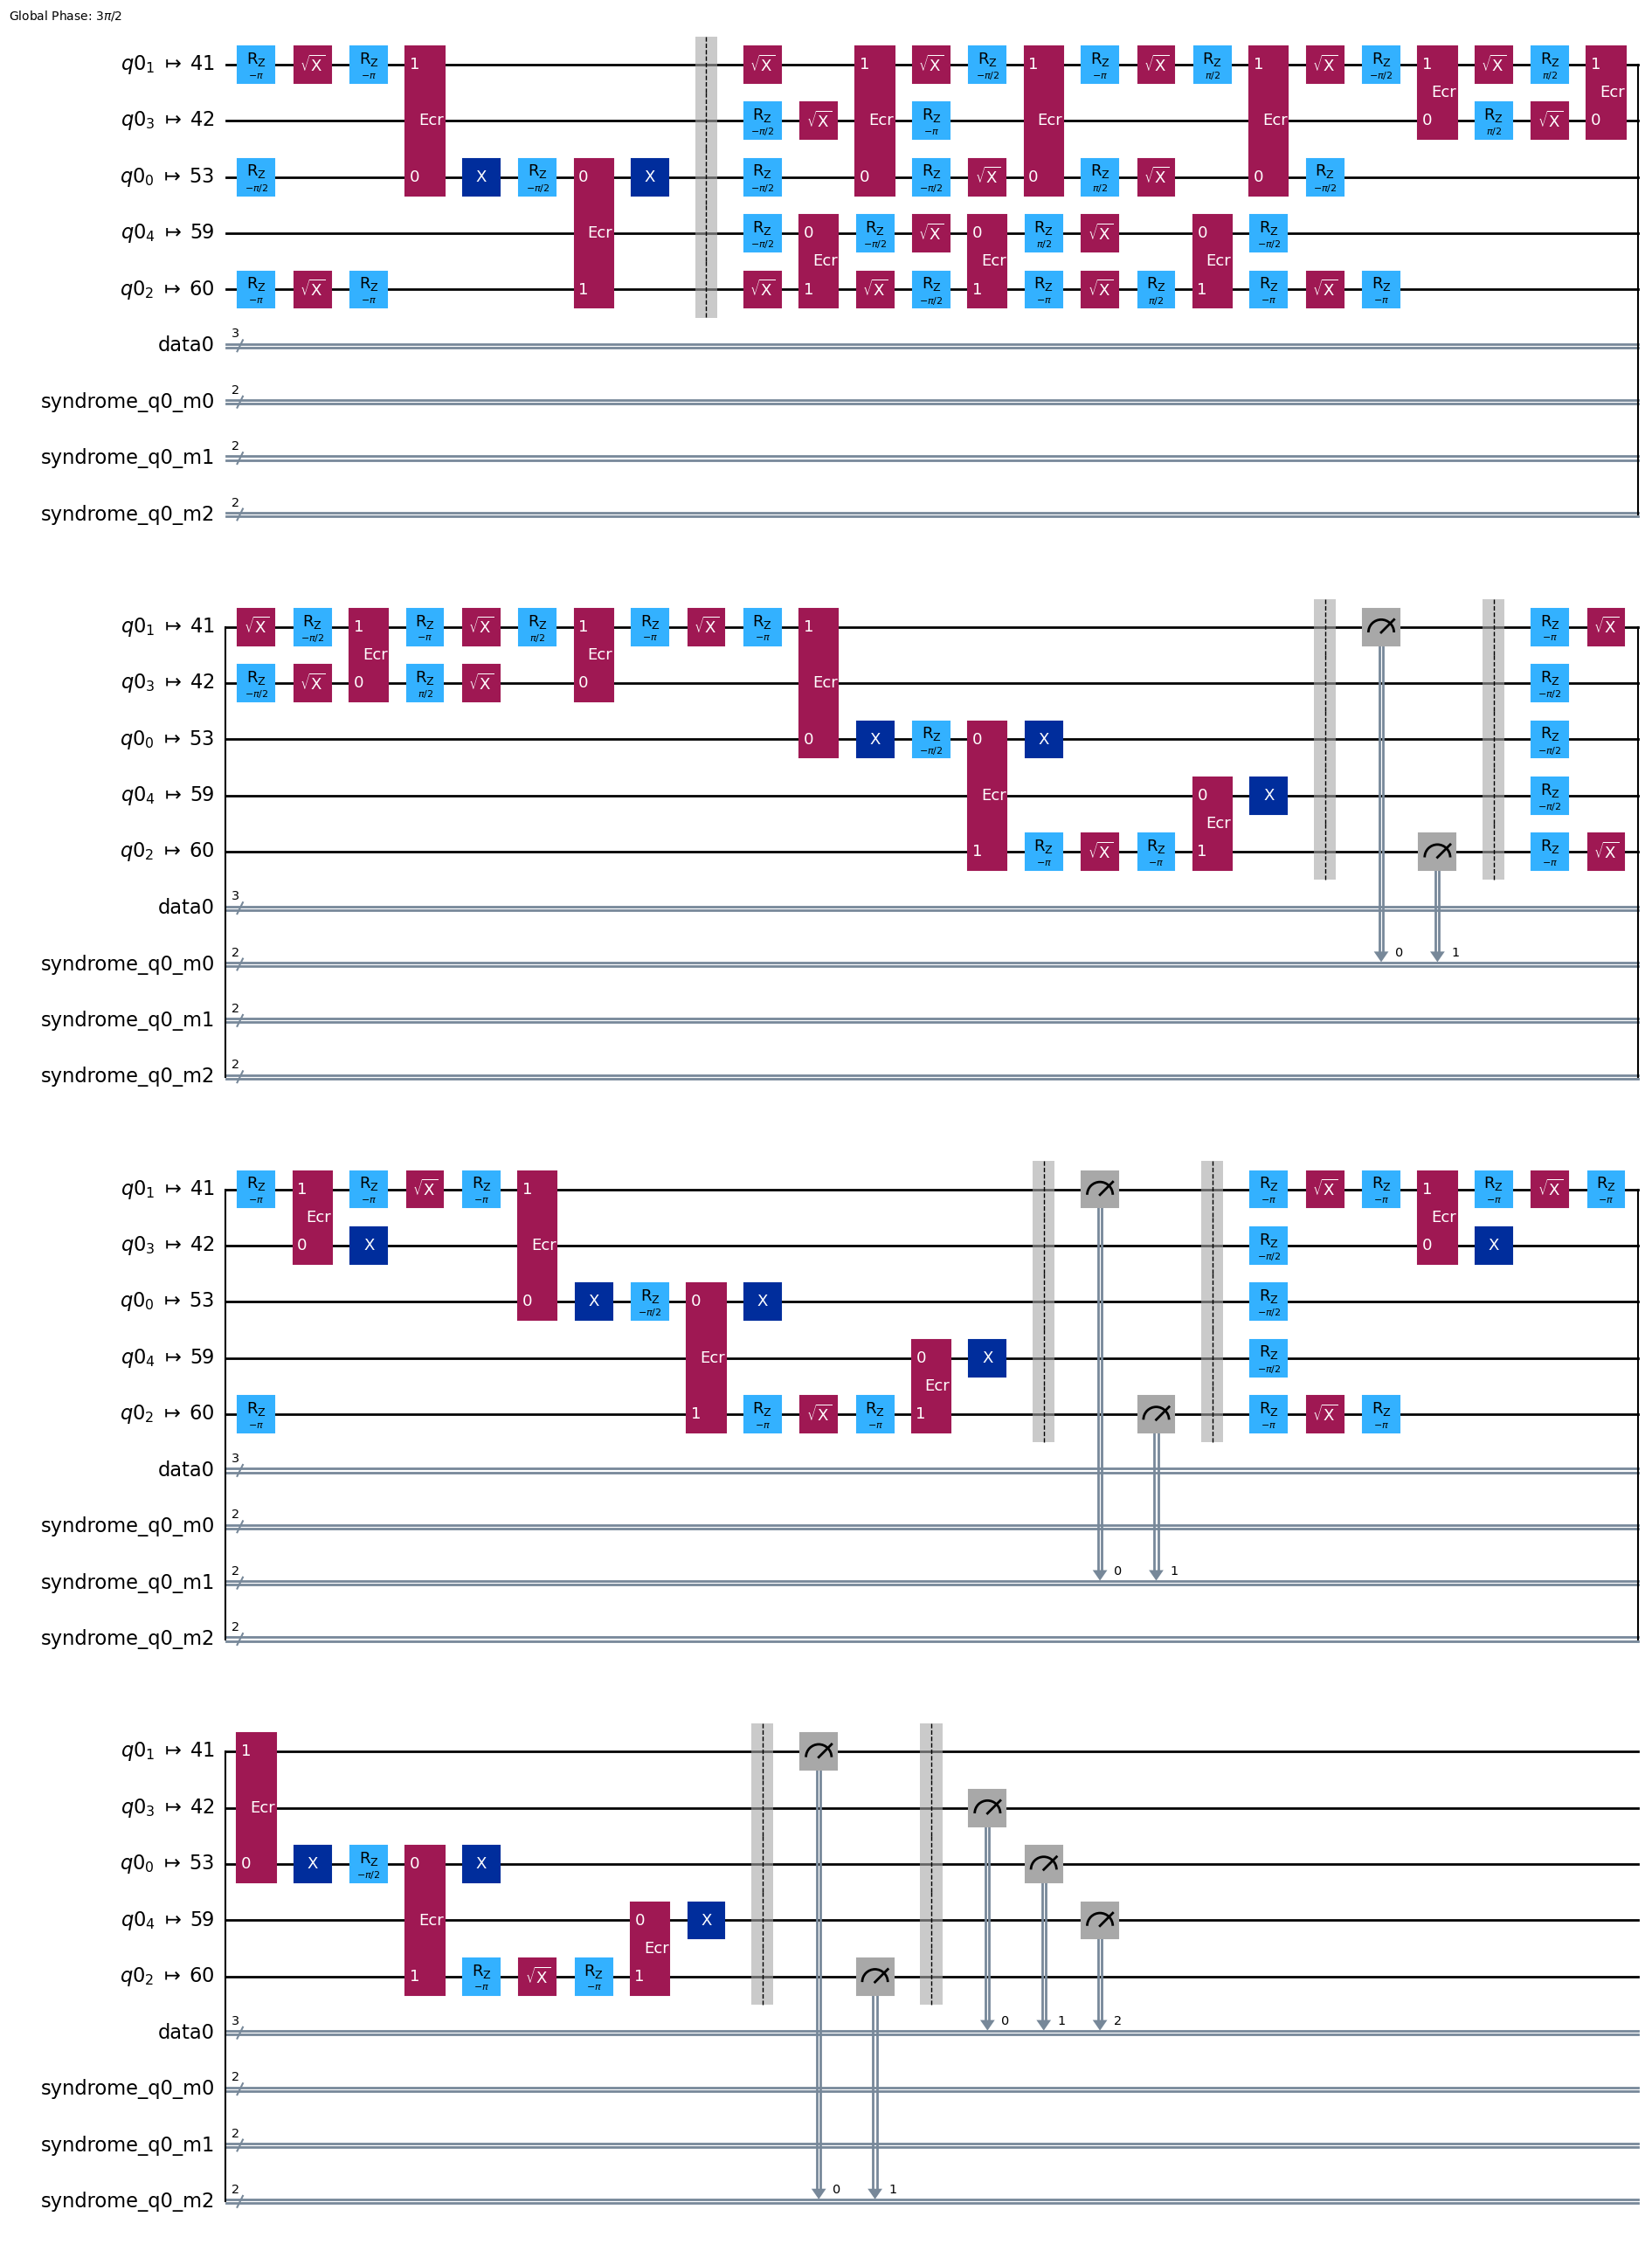

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [12]:
sampler = Sampler(backend)
shots = 5000000
job = sampler.run([isa_circuit], shots=shots)
result = job.result()[0]

In [13]:


data = []
for i in range(logic_qubits):
    logic = [eval(f"result.data.data{i}.get_bitstrings()")]
    print(eval(f"result.data.data{i}.get_counts()"))

    for m in range(number_of_measurements):
        d = eval(f"result.data.syndrome_q{i}_m{m}.get_bitstrings()")
        logic.append(d)

    data.append(logic)


data = np.array(data)
# print("\nData:")
# for i, logicQ in enumerate(data):
#     print(f"\nLogicq{i}:")
#     for d in logicQ:
#         print(d)

{'000': 4517184, '100': 171831, '001': 131963, '010': 131130, '011': 22180, '110': 5138, '101': 16880, '111': 3694}


In [14]:
# Remove trivial syndromes before saving data

trivial_index = []
for i in range(shots):
    if int("".join(data[0,:,i])) == 0:
        trivial_index.append(i)
data = np.delete(data, trivial_index, axis=2)

print(len(trivial_index))

4292381


In [15]:
print(data[0,:,:])

non_trivial_shots = data.shape[2]
print(non_trivial_shots)

[['100' '000' '001' ... '100' '101' '000']
 ['00' '10' '01' ... '00' '00' '01']
 ['10' '10' '00' ... '00' '11' '01']
 ['00' '10' '01' ... '00' '00' '01']]
707619


In [16]:
import repetition_code_data as rcd
import json

settings = ["test", backend_name, qubits_per_logical, non_trivial_shots, number_of_measurements, "0.0"]

data_handler = rcd.repetition_code_data(*settings)

data = data.tolist()

with open(data_handler.run + '_data/Raw_data/result_matrix_'+data_handler.backend_name+'_'+str(data_handler.code_distance)+'_'
    +str(data_handler.shots)+'_'+str(data_handler.time_steps)+'_'+data_handler.version+'.json', 'w') as outfile:
    outfile.write(json.dumps(data[0]))

# data_handler.format()
data_handler.format(raw_data=data[0])
# data_handler.error_analyzer_q()
# data_handler.error_analyzer_t()

({0: [[0, 0], [0, 0], [1, 0], [0, 0], [1, 0]],
  1: [[0, 0], [1, 0], [1, 0], [1, 0], [0, 0]],
  2: [[0, 0], [0, 1], [0, 0], [0, 1], [0, 1]],
  3: [[0, 0], [0, 0], [0, 0], [0, 0], [1, 1]],
  4: [[0, 0], [0, 0], [1, 0], [0, 0], [1, 0]],
  5: [[0, 0], [0, 0], [0, 0], [0, 0], [1, 1]],
  6: [[0, 0], [0, 0], [0, 0], [1, 0], [0, 0]],
  7: [[0, 0], [0, 0], [0, 0], [0, 0], [0, 1]],
  8: [[0, 0], [0, 0], [0, 0], [0, 0], [1, 0]],
  9: [[0, 0], [0, 1], [0, 1], [0, 1], [0, 0]],
  10: [[0, 0], [0, 1], [0, 1], [0, 1], [0, 0]],
  11: [[0, 0], [1, 0], [1, 0], [1, 0], [0, 0]],
  12: [[0, 0], [0, 1], [0, 1], [0, 1], [0, 1]],
  13: [[0, 0], [0, 1], [0, 1], [0, 0], [0, 1]],
  14: [[0, 0], [0, 0], [0, 0], [1, 0], [0, 0]],
  15: [[0, 0], [1, 1], [0, 0], [1, 1], [0, 0]],
  16: [[0, 0], [0, 0], [0, 0], [1, 0], [1, 1]],
  17: [[0, 0], [0, 0], [1, 0], [0, 0], [1, 0]],
  18: [[0, 0], [0, 0], [0, 0], [0, 0], [1, 0]],
  19: [[0, 0], [0, 0], [1, 0], [0, 0], [1, 0]],
  20: [[0, 0], [0, 0], [0, 0], [0, 0], [1, 1]],
  

In [11]:
# import repetition_code_MWPM as rcdmwpm

# mwpm = rcdmwpm.repetition_code_MWPM(*settings)

# mwpm.MWPM()

In [52]:
# Remove trivial cases from existing data

import json
from pathlib import Path
import repetition_code_data as rcd

# Specify data file
distance = 7
folder_name = f"d{distance}_t3_torino_testing"
backend_name = "ibm_torino"
num_qubits = distance
logic_qubits = 1
qubits_per_logical = distance
n_measurements = 3
n_shots = 500000
version = "0.0"

# Open file
with open("data/"+ folder_name + '/Raw_data/result_matrix_'+backend_name+'_'+str(distance)+'_'
        +str(n_shots)+'_'+str(n_measurements)+'_'+version+'.json', 'r') as infile:
    raw_data = json.load(infile)

# Find all trivial indices
trivial_index = []
for i in range(n_shots):
    #print("Raw data sample:")
    #print("Here:",raw_data)
    if int("".join(raw_data[0][i])) == 0:
        trivial_index.append(i)

# Delete all trivial cases
trivial_shots = len(trivial_index)
print("Trivial cases:", trivial_shots)
raw_data = np.delete(raw_data, trivial_index, axis=1)

# Print amount of non-trivial shots
non_trivial_shots = raw_data.shape[1]
print("Non-trivial cases:",non_trivial_shots)
print("Fraction of total cases:",round(non_trivial_shots*100/(non_trivial_shots+trivial_shots),1),"%")

# Create directories for data
run_name = folder_name + "_notrivial"

paths = ["data/"+run_name, "data/"+run_name+"/Detector_data", "data/"+run_name+"/Error_matrix", "data/"+run_name+"/Format_data", "data/"+run_name+"/Outcome_data", "data/"+run_name+"/Raw_data"]

for p in paths:
    directory_path = Path(p)
    # Create the directory
    try:
        directory_path.mkdir()
        print(f"Directory '{directory_path}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_path}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Use repetition_code_data class to structure and save data
settings = [run_name, backend_name, qubits_per_logical, non_trivial_shots, n_measurements, version]
data_handler = rcd.repetition_code_data(*settings)

print("data_handler.run:",data_handler.run)


# Json-dump raw data
with open("data/"+data_handler.run + '/Raw_data/result_matrix_'+data_handler.backend_name+'_'+str(data_handler.code_distance)+'_'
    +str(data_handler.shots)+'_'+str(data_handler.time_steps)+'_'+data_handler.version+'.json', 'w') as outfile:
    outfile.write(json.dumps(raw_data.tolist()))

# Format raw data
data_handler.format()

Trivial cases: 242172
Non-trivial cases: 482716
Fraction of total cases: 66.6 %
Directory 'data/d9_t3_torino_notrivial' created successfully.
Directory 'data/d9_t3_torino_notrivial/Detector_data' created successfully.
Directory 'data/d9_t3_torino_notrivial/Error_matrix' created successfully.
Directory 'data/d9_t3_torino_notrivial/Format_data' created successfully.
Directory 'data/d9_t3_torino_notrivial/Outcome_data' created successfully.
Directory 'data/d9_t3_torino_notrivial/Raw_data' created successfully.
data_handler.run: d9_t3_torino_notrivial


({0: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 1, 1, 1, 0, 0, 0],
   [0, 0, 1, 1, 1, 1, 0, 0]],
  1: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 1, 0, 1],
   [0, 0, 1, 1, 0, 0, 0, 0],
   [0, 0, 1, 0, 0, 1, 0, 1],
   [0, 0, 1, 1, 0, 1, 0, 1]],
  2: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 1, 1, 0, 0],
   [0, 0, 1, 0, 0, 0, 0, 0],
   [0, 0, 1, 0, 1, 1, 0, 0],
   [0, 0, 1, 1, 1, 1, 0, 0]],
  3: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 1, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 1, 0, 0, 0]],
  4: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 0, 0, 1],
   [0, 1, 0, 0, 0, 0, 0, 0]],
  5: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 1, 1, 0, 0, 0, 0],
   [0, 0, 1, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0, 0, 0],
   [1, 1, 1, 1, 0, 0, 0, 0]],
  6: [[0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 1, 1, 0, 0, 0, 0],
   [0, 0, 0, 0, 